***by Hoang Van Le* - prepared for COMP2200 Data Science**
# Analysis on cycling data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline

## Loading Data
Loading and inspecting data.

In [3]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava.index = strava.index.tz_convert('UTC')
strava.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
date,,,,,,,,,,
2018-01-02 20:47:51+00:00,100.6,21.0,73.8,False,15.2,94,316.00 m,10,73,Ride
2018-01-04 01:36:53+00:00,NaN,24.0,131.7,False,18.0,52,236.00 m,5,46,Ride
2018-01-04 02:56:00+00:00,83.1,25.0,13.8,False,0.0,3,0.00 m,2,2,Ride
2018-01-04 05:37:04+00:00,110.1,24.0,113.6,False,22.9,77,246.00 m,8,64,Ride
2018-01-05 19:22:46+00:00,110.9,20.0,147.7,True,58.4,189,676.00 m,12,144,Ride


In [4]:
strava.shape

(268, 10)

The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [5]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
cheetah.head()

,date,time,filename,axPower,aPower Relative Intensity,aBikeScore,Skiba aVI,aPower Response Index,aIsoPower,aIF,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,01/28/18,06:39:49,2018_01_28_06_39_49.json,202.211,0.75452,16.6520,1.31920,1.67755,223.621,0.83441,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,01/28/18,07:01:32,2018_01_28_07_01_32.json,226.039,0.84343,80.2669,1.21137,1.54250,246.185,0.91860,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,02/01/18,08:13:34,2018_02_01_08_13_34.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,02/06/18,08:06:42,2018_02_06_08_06_42.json,221.672,0.82714,78.8866,1.35775,1.86002,254.409,0.94929,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,02/07/18,17:59:05,2018_02_07_17_59_05.json,218.211,0.81422,159.4590,1.47188,1.74658,233.780,0.87231,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


In [6]:
cheetah.shape

(251, 362)

## Combining two data frames

The block of code belows combines the two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index). The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [7]:
joined_data = strava.join( cheetah, how = 'inner') #inner join by indexes/Time, adding the columns
print(joined_data.shape)
joined_data.head()

(243, 372)


,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-27 19:39:49+00:00,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-27 20:01:32+00:00,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-01-31 21:13:34+00:00,109.8,19.0,143.0,False,26.3,649,612.00 m,6,113,Ride,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-05 21:06:42+00:00,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 06:59:05+00:00,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


## Removing rides with no measured power

In [8]:
# Removing rides with no power reading
joined_data = joined_data.drop(joined_data[joined_data['device_watts']==False].index)
print(joined_data.shape)
joined_data.head(10)

(209, 372)


,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-27 19:39:49+00:00,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-27 20:01:32+00:00,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-05 21:06:42+00:00,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 06:59:05+00:00,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780
2018-02-09 19:18:03+00:00,123.0,20.0,145.9,True,59.8,193,656.00 m,22,139,Ride,...,0,0,0,0,0,0,0,212.726,0.79375,147.7970
2018-02-10 20:21:37+00:00,103.9,17.0,134.9,True,7.8,19,92.00 m,8,18,Ride,...,0,0,0,0,0,0,0,192.117,0.71685,15.7590
2018-02-10 20:46:02+00:00,152.1,19.0,198.9,True,31.0,49,387.00 m,21,49,Race,...,0,0,0,0,0,0,0,244.500,0.91231,69.2902
2018-02-14 20:07:12+00:00,125.3,19.0,148.9,True,47.8,143,922.00 m,6,132,Ride,...,0,0,0,0,0,0,0,222.957,0.83193,155.9740
2018-02-15 07:18:46+00:00,NaN,22.0,126.1,True,8.9,29,191.00 m,5,25,Ride,...,0,0,0,0,0,0,0,223.451,0.83377,30.7036
2018-02-16 19:19:04+00:00,124.9,20.0,159.6,True,58.6,212,659.00 m,19,132,Ride,...,0,0,0,0,0,0,0,222.469,0.83011,154.5070


## Obtaining districutions key variables
### Distribution of Time
The Time values are stored as indexes in the dataframe. The block of codes below obtains the distribution for Time as indexes.

Text(0.5, 1.0, 'Distribution of Time')

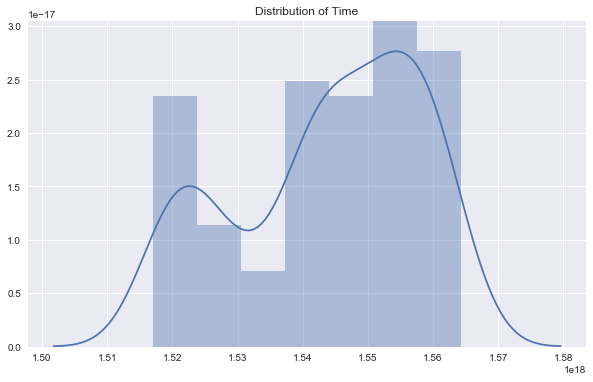

In [9]:
#Exploring distributions of time variable
plt.figure(figsize=(10,6))
sns.distplot(joined_data.index)
plt.title('Distribution of Time')

### Distribution of Distance

Text(0.5, 1.0, 'Distribution of Distance')

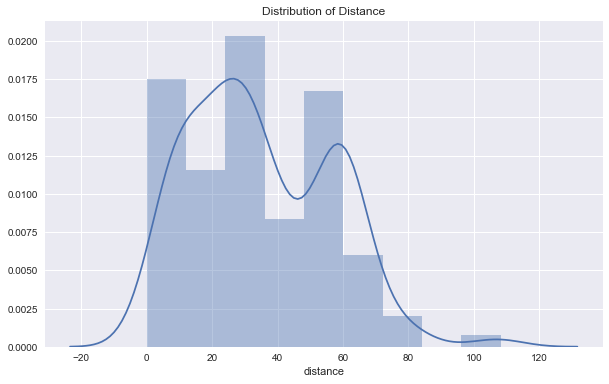

In [10]:
#Exploring distributions of distance variable
plt.figure(figsize=(10,6))
sns.distplot(joined_data.distance)
plt.title('Distribution of Distance')

### Distribution of Average Speed

Text(0.5, 1.0, 'Distribution of Average Speed')

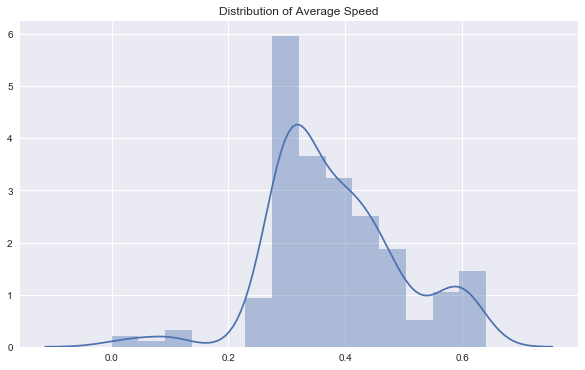

In [11]:
#Exploring distributions of average speed variable
plt.figure(figsize=(10,6))
sns.distplot(joined_data.distance/joined_data.elapsed_time)
plt.title('Distribution of Average Speed')

### Distribution of Average Power

Text(0.5, 1.0, 'Distribution of Average Power')

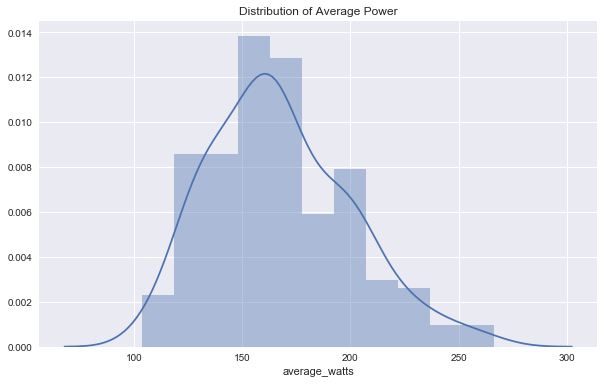

In [12]:
#Exploring distributions of average power variable
plt.figure(figsize=(10,6))
sns.distplot(joined_data.average_watts)
plt.title('Distribution of Average Power')

### Distribution of Training Stress Score

Text(0.5, 1.0, 'Distribution of Training Stress Score')

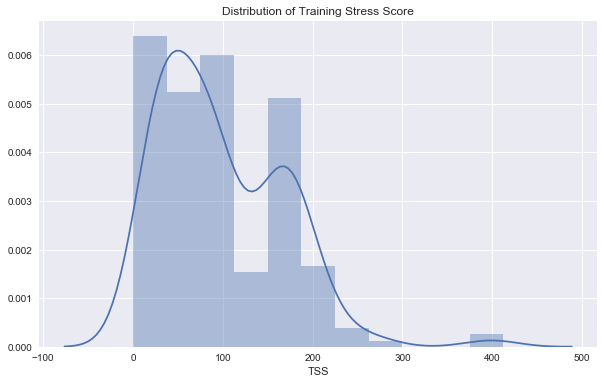

In [13]:
#Exploring distributions of TSS variable
plt.figure(figsize= (10,6))
sns.distplot(joined_data.TSS)
plt.title('Distribution of Training Stress Score')

### Interpretation of the obtained distributions:
The distribution of Training Stress Score (TSS) shows a possibility of a Bimodal Distribution, whereas the distribution of TSS shows skewness to the right.

The histogram that illustrates Distance suggests a Multimodal Distribution with some right skewness.

Whilst distributions of Average Speed and Power both seem Unimodal, normality is only reasonable to assume for the Power distribution, with slight right-skewedness.

### Correlation matrix between variables of interest

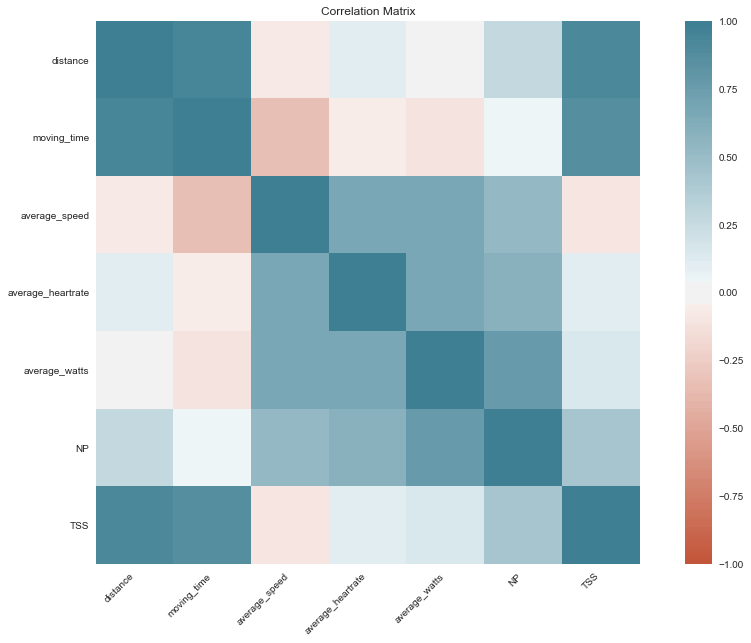

In [14]:
average_speed=joined_data.distance/joined_data.elapsed_time
joined_data['average_speed'] = average_speed
corrMatrix = joined_data[['distance', 'moving_time', 'average_speed', 'average_heartrate', 'average_watts', 'NP', 'TSS', 'elevation_gain']].corr()

plt.figure(figsize=(16,10))
plt.title('Correlation Matrix')
ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Interpretation:
Since a [correlation matrix](https://www.displayr.com/what-is-a-correlation-matrix/#:~:text=A%20correlation%20matrix%20is%20a,a%20diagnostic%20for%20advanced%20analyses.) shows the correlation coefficients between variables in the data set regardless of having sufficient evidence to support whether there is a relation between any two variables, it would be naive to interpret the relations between variables based on the correlation matrix above. However, we can interpret how they correlate with one another.

The correlation matrix shows that there is significant positive correlation between Distance and Moving time, which is logically expected as distance is a function of time and they are proportional. Interestingly, whilst the distance is also a function of speed, slightly inverse correlations are observed between Average Speed and Distance, and Moving Time.

Average Speed visibly positively correlate with Average Heart Rate, Average Watts and Normalised Power. This could mean that the higher the speed, the higher the heart rate and power, which is reasonable and expected, because [our hearts pump faster when we exercise, and as we exercise, we are burning calories - generating power](https://www.scientificamerican.com/article/jumping-heartbeat-exercise-your-pulse-bring-science-home/#:~:text=When%20you%20are%20exercising%2C%20your,air%2C%20hence%20the%20harder%20breathing.). Nevertheless, we need to be mindful that such causations between speed, heart rate, and power are not supported by enough evidence yet.

In addition, Training Stress Score has noticeably high positive correlation with Distance and Moving Time. This reveals that the estimated training load and physiological stress created by a session could be proportional to how long that session is. As explained in their [glossary](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary), such correlation is justifiable and consistent with that TSS is conceptually modeled after the heart rate-based training load.

A scatter plot matrix is obtained below for further investigatigation.

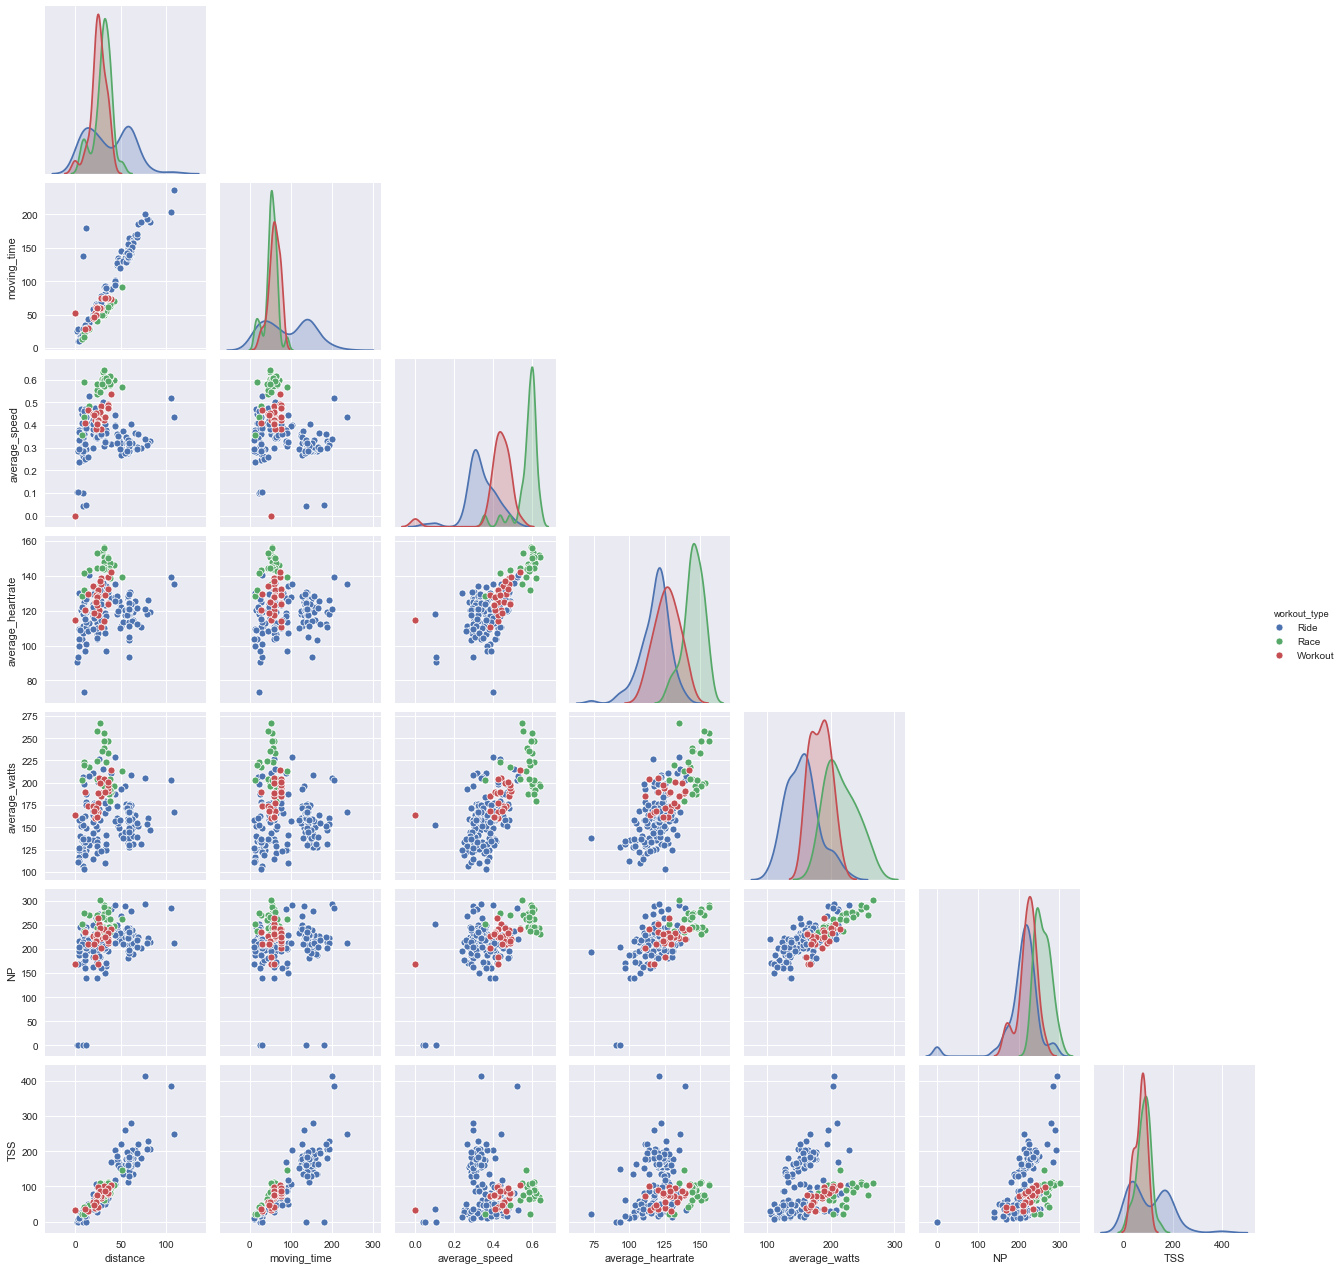

In [15]:
interested_vars = pd.DataFrame(joined_data, columns= ['distance', 'moving_time', 'average_speed', 'average_heartrate', 'average_watts', 'NP', 'TSS', 'elevation_gain', 'workout_type'])
sns.pairplot(interested_vars, hue="workout_type", corner = True)

**Interpretation:** The aforementioned relations look reasonbly linear in the scatter plots matrix. However, they are yet to be confirmed by further models and tests. 

The scatter plots are colors coded by workout_type, this also helps us see the different characteristics between the three categories.

### Cycling by types
The codes below created three new data frames for three different cycling categories: **Race**, **Workout**, and **Ride** accordingly.

In [16]:
set(joined_data['workout_type'])

{'Race', 'Ride', 'Workout'}

In [17]:
Race = joined_data[joined_data['workout_type']=='Race'].drop(columns='workout_type')
Workout = joined_data[joined_data['workout_type']=='Workout'].drop(columns='workout_type')
Ride = joined_data[joined_data['workout_type']=='Ride'].drop(columns='workout_type')
print(Race.shape, Workout.shape, Ride.shape)
print(joined_data.shape[0]-Race.shape[0]-Workout.shape[0]-Ride.shape[0])

(29, 372) (25, 372) (155, 372)
0


The shapes of the three data frames shows that the numbers of replicates in each category are unequal, making this an unbalanced study. To be more specific, Ride weights a lot more than the other two categories.

The scatter plots mattrix shows strong visual indication of linear relation between average_watts and NP, with Race ranks highest, then Workout and Ride. However, Ride seems to scatter and spread a lot more than the other two. This might be explained by the unbalance of the study. Similar patterns can also be seen in average_speed and average_heartrate. Although it is common sense that these variables are positively proportional, the variation in average_heartrate for a value of average_speed for Ride looks quite large. Below are the two discussed scatter plots.


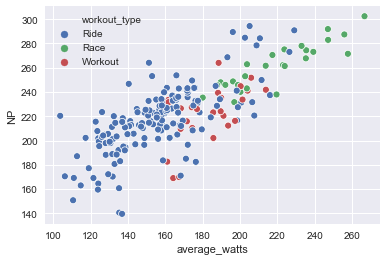

In [18]:
sns.scatterplot(data = joined_data, x= "average_watts", y= "NP", hue = "workout_type")

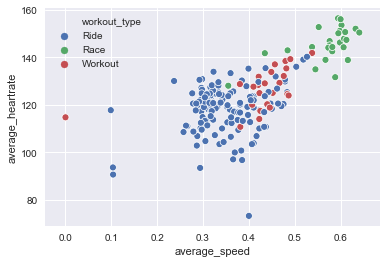

In [19]:
sns.scatterplot(data = joined_data, x= "average_speed", y= "average_heartrate", hue = "workout_type")

The scatter plot below shows the general trend between TSS and distance, the higher the distance, the higher the Stress.

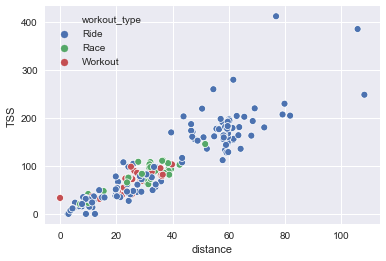

In [20]:
sns.scatterplot(data = joined_data, x= "distance", y= "TSS", hue = "workout_type")

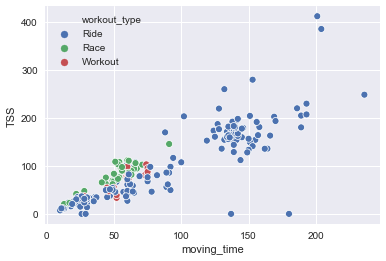

In [21]:
sns.scatterplot(data = joined_data, x= "moving_time", y= "TSS", hue = "workout_type")

Similarly, the longer the moving_time, the higher the Stress, in general.

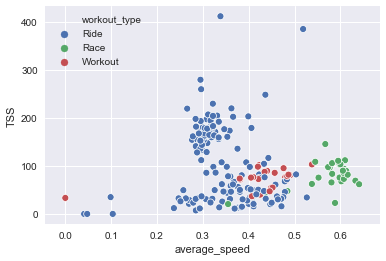

In [22]:
sns.scatterplot(data = joined_data, x="average_speed", y= "TSS", hue = "workout_type")

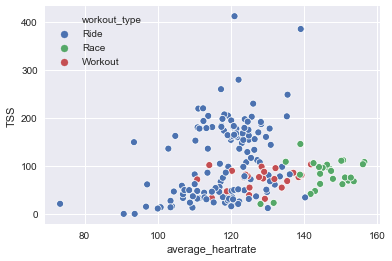

In [23]:
sns.scatterplot(data = joined_data, x="average_heartrate" , y="TSS", hue = "workout_type")

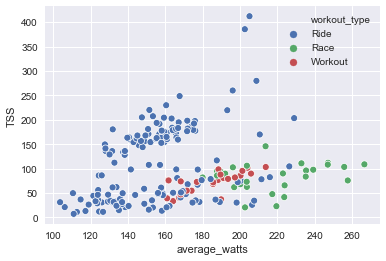

In [24]:
sns.scatterplot(data = joined_data, x= "average_watts", y="TSS" , hue = "workout_type")

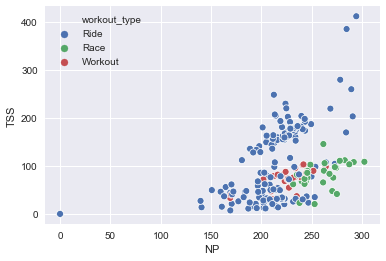

In [25]:
sns.scatterplot(data = joined_data, x="NP", y="TSS" , hue = "workout_type")

average_speed, average_heartrate, average_watts and NP have less correlation to TSS.

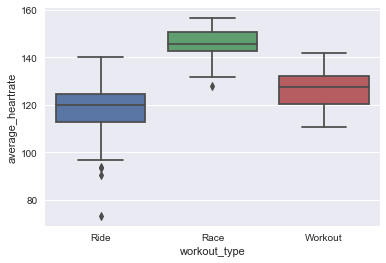

In [26]:
sns.boxplot(x="workout_type", y="average_heartrate", data = joined_data)

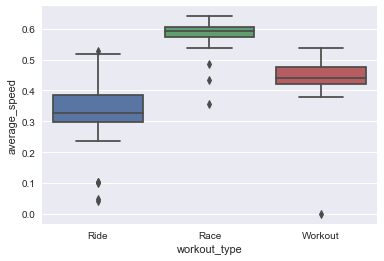

In [27]:
sns.boxplot(x="workout_type", y="average_speed", data = joined_data)

(array([3., 2., 1., 2., 0., 4., 5., 3., 2., 3.]),
 array([ 31.3613 ,  38.54667,  45.73204,  52.91741,  60.10278,  67.28815,
         74.47352,  81.65889,  88.84426,  96.02963, 103.215  ]),
 <a list of 10 Patch objects>)

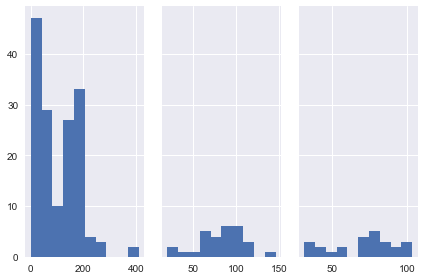

In [28]:
fig, axs = plt.subplots(1, 3 , sharey = True, tight_layout = True)

axs[0].hist(Ride.TSS)
axs[1].hist(Race.TSS)
axs[2].hist(Workout.TSS)

### The relationship between rides and weather

In [29]:
#reading the weather data
weather18 = pd.read_csv('data/weather_data_2018.csv')
weather18.index = pd.to_datetime(weather18[['Year','Month','Day']])
print(weather18.shape)
weather18.head()

(365, 8)


,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
2018-01-01,IDCJAC0010,66212,2018,1,1,30.9,1.0,Y
2018-01-02,IDCJAC0010,66212,2018,1,2,28.8,1.0,Y
2018-01-03,IDCJAC0010,66212,2018,1,3,25.3,1.0,Y
2018-01-04,IDCJAC0010,66212,2018,1,4,25.4,1.0,Y
2018-01-05,IDCJAC0010,66212,2018,1,5,28.9,1.0,Y


In [30]:
weather19 = pd.read_csv('data/weather_data_2019.csv')
weather19.index = pd.to_datetime(weather19[['Year','Month','Day']])
print(weather19.shape)
weather19.head()

(365, 8)


,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
2019-01-01,IDCJAC0010,66212,2019,1,1,34.0,1.0,Y
2019-01-02,IDCJAC0010,66212,2019,1,2,30.6,1.0,Y
2019-01-03,IDCJAC0010,66212,2019,1,3,28.9,1.0,Y
2019-01-04,IDCJAC0010,66212,2019,1,4,33.7,1.0,Y
2019-01-05,IDCJAC0010,66212,2019,1,5,39.3,1.0,Y


In [31]:
#merging weather18 and weather19
weather = pd.concat([weather18, weather19])
print(weather.shape)
#keeping columns of interest
weather = weather[['Maximum temperature (Degree C)']]
print(weather.shape)
weather.head()

(730, 8)
(730, 1)


,Maximum temperature (Degree C)
2018-01-01,30.9
2018-01-02,28.8
2018-01-03,25.3
2018-01-04,25.4
2018-01-05,28.9


In [32]:
weather.first_valid_index()

Timestamp('2018-01-01 00:00:00')

In [35]:
import warnings
warnings.filterwarnings('ignore')

#creating dataframe rides with selected columns and date from joined_data
rides = joined_data[['distance', 'average_speed','workout_type']]
print(rides.shape)
rides['date'] = pd.to_datetime([d.date() for d in rides.index])
print(rides.shape)
rides.head()

(209, 3)
(209, 4)


,distance,average_speed,workout_type,date
2018-01-27 19:39:49+00:00,7.6,0.447059,Ride,2018-01-27
2018-01-27 20:01:32+00:00,38.6,0.576119,Race,2018-01-27
2018-02-05 21:06:42+00:00,24.3,0.352174,Ride,2018-02-05
2018-02-07 06:59:05+00:00,47.1,0.327083,Ride,2018-02-07
2018-02-09 19:18:03+00:00,59.8,0.309845,Ride,2018-02-09


In [36]:
#joining weather and rides
result = rides.join(weather, on = 'date')
print(result.shape)
result.head()

(209, 5)


,distance,average_speed,workout_type,date,Maximum temperature (Degree C)
2018-01-27 19:39:49+00:00,7.6,0.447059,Ride,2018-01-27,30.4
2018-01-27 20:01:32+00:00,38.6,0.576119,Race,2018-01-27,30.4
2018-02-05 21:06:42+00:00,24.3,0.352174,Ride,2018-02-05,27.4
2018-02-07 06:59:05+00:00,47.1,0.327083,Ride,2018-02-07,28.1
2018-02-09 19:18:03+00:00,59.8,0.309845,Ride,2018-02-09,31.9


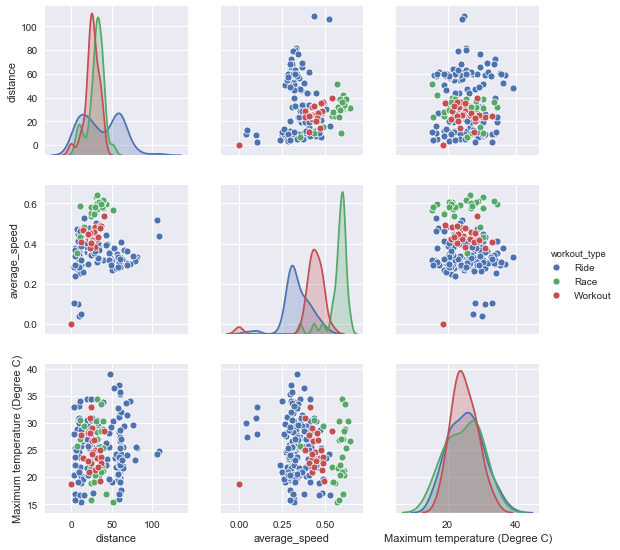

In [37]:
sns.pairplot(result, vars = ["distance", "average_speed", "Maximum temperature (Degree C)"], hue = "workout_type")

**Interpretation:**
* average_speed for each workout_type seems to vary very little reagardless of temparature. It's noticable how the three workout types form three clusters on average_speed.
* Otherwise, the variables don't seem to have relations.

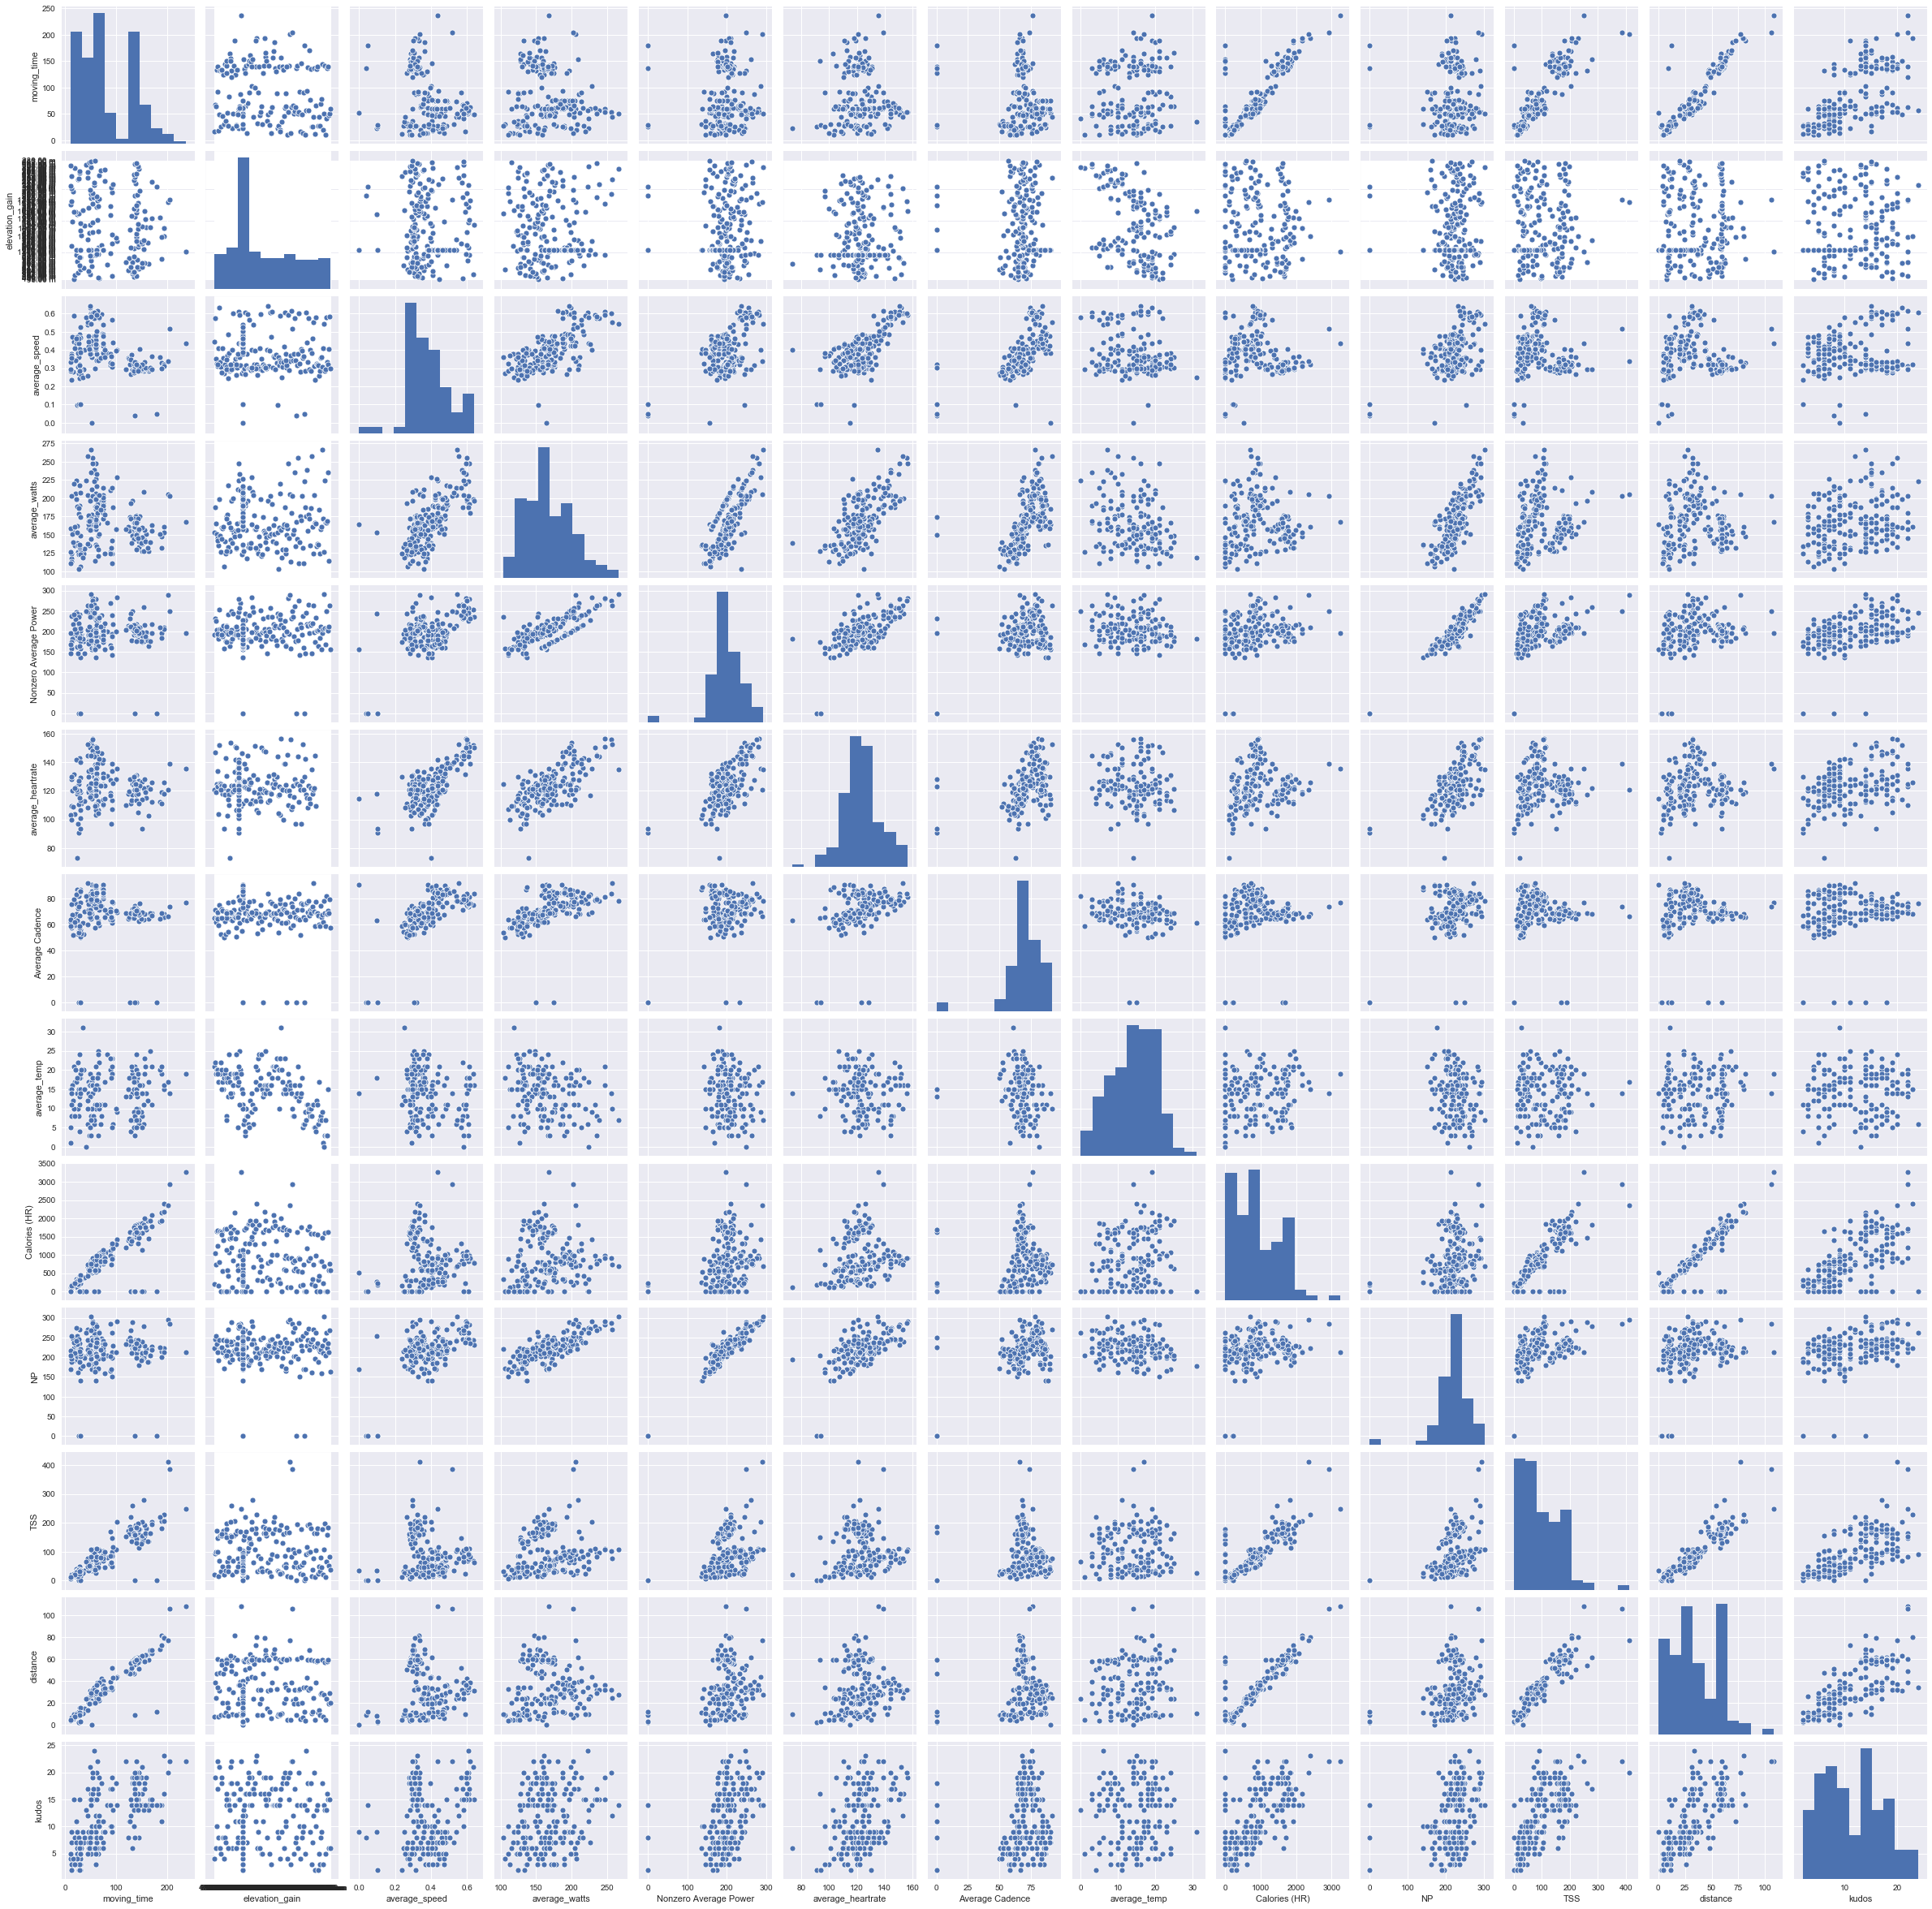

In [38]:
sns.pairplot(joined_data, 
             vars =[ "moving_time", "elevation_gain", "average_speed", "average_watts", 
                     "Nonzero Average Power", "average_heartrate", "Average Cadence", "average_temp",
                     "Calories (HR)", "NP", "TSS", "distance", "kudos"])

Kudos seems to have a linear relation with distance and TSS, however, weak.